# box creation and vector rotation

Object of the notebook is to validate vector rotations between native (lon, lat) (east, north) orientations and local orientation.

To find the directions ($\theta_\mathrm{lon}$, $\theta_\mathrm{lat}$) of the latitude and longitude unit vectors ($\mathbf{e_\mathrm{lon}}$, $\mathbf{e_\mathrm{lat}}$), one uses the fact that these directions are such that elementary displacements along each direction conserves longitude and latitude respectively.
These vectors need to be at right angle from the latitude and longitude gradients in the local $(x,y)$ coordinate system and form a direct basis.
To find the longitude unit vector for example:

$
\begin{align}
\delta \mathrm{lat} &= \delta x \; \partial_x \mathrm{lat} + \delta y \;  \partial_y \mathrm{lat} = 0, \\
&\propto e_{\mathrm{lon}} \cdot \nabla \mathrm{lat}
\end{align}
$

which leads to:

$
\begin{align}
e_{\mathrm{lon}} \propto \pm \mathbf{k} \times \nabla \mathrm{lat}
\end{align}
$

Similarly:

$
\begin{align}
e_{\mathrm{lat}} \propto \pm \mathbf{k} \times \nabla \mathrm{lon}
\end{align}
$

The basis needs to be direct which leads to:

$
\begin{align}
e_{\mathrm{lon}} &\propto - \mathbf{k} \times \nabla \mathrm{lat}, \\
&\propto (\partial_y \mathrm{lat}, -\partial_x \mathrm{lat}), \\
&= (\cos \theta_{\mathrm{lon}}, \sin \theta_{\mathrm{lon}} ), \\
e_{\mathrm{lat}} &\propto   \mathbf{k} \times \nabla \mathrm{lon}, \\
&\propto (-\partial_y \mathrm{lon}, \partial_x \mathrm{lon}), \\
&= (\cos \theta_{\mathrm{lat}}, \sin \theta_{\mathrm{lat}} ).
\end{align}
$

with:

$
\begin{align}
\theta_{\mathrm{lon}} &= \mathrm{atan2} (-\partial_x \mathrm{lat}, \partial_y \mathrm{lat}), \\
\theta_{\mathrm{lat}} &= \mathrm{atan2} (\partial_x \mathrm{lon}, -\partial_y \mathrm{lon}),
\end{align}
$

Because projections are not allways conformal (i.e. preserving angles), the difference between $\theta_\mathrm{lon}$ and $\theta_\mathrm{lat}$ is not exactly $\pi/2$ in general.

To rotate a vector ($v_e$, $v_n$) in the (x,y) coordinate system on needs to perform:

$
\begin{align}
v_x &= v_e \cos \theta_\mathrm{lon} + v_n \cos \theta_\mathrm{lat} , \\
v_y &= v_e \sin \theta_\mathrm{lon} + v_n \sin \theta_\mathrm{lat} ,
\end{align}
$


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.sat as sat

In [2]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=4, cores=4)
    w = cluster.scale(jobs=5)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45240/status,
Dashboard: http://127.0.0.1:45240/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55901,Workers: 8
Dashboard: http://127.0.0.1:45240/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:49111,Total threads: 7
Dashboard: http://127.0.0.1:52641/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:46183,


In [3]:
#load_collocalisations(2018)
nc_files = box.load_collocalisations(2018,drifter='gps')
ds1=box.build_dataset(nc_files,10)


In [4]:
ds=ds1.isel(obs=0)
ds

<xarray.Dataset>
Dimensions:                        (site_obs: 1489, alti_time: 21, box_x: 80,
                                    box_y: 40, alti_time_mid: 20)
Coordinates: (12/19)
    time                           datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    lon                            float64 dask.array<chunksize=(), meta=np.ndarray>
    lat                            float64 dask.array<chunksize=(), meta=np.ndarray>
    drifter_time                   (site_obs) datetime64[ns] dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_lon                    (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_lat                    (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    ...                             ...
    alti_x                         (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    alti_y                         (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * alti_time                      (alti_time) int64 0 1 2 3 4 ... 17 18 19 20
  * alti_time_mid                  (alti_time_mid) float64 0.5 1.5 ... 18.5 19.5
    alti_x_mid                     (alti_time_mid) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    alti_y_mid                     (alti_time_mid) float64 dask.array<chunksize=(20,), meta=np.ndarray>
Dimensions without coordinates: site_obs
Data variables: (12/57)
    __site_id                      object dask.array<chunksize=(), meta=np.ndarray>
    __site_name                    object dask.array<chunksize=(), meta=np.ndarray>
    drifter_rowsize                (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_WMO                    (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_expno                  (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_deploy_date            (site_obs) datetime64[ns] dask.array<chunksize=(1489,), meta=np.ndarray>
    ...                             ...
    drifter_theta_lat              (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_vx                     (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_vy                     (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    g_grad_sla                     (alti_time_mid) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    g_grad_sla_denoised            (alti_time_mid) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    f                              float64 dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__gps
    __time_coverage_end:    2018-07-01T00:00:00
    __time_coverage_start:  2018-06-01T00:00:00

### Define problem parameters: box dimension, orientation, position


dx, Lx = 1e4, 3000*1e3
dy, Ly = 1e4, 2000*1e3
ds = xr.Dataset(dict(x=np.arange(-Lx/2,Lx/2,dx), y=np.arange(-Ly/2,Ly/2,dy)))

phi = 120
lonc, latc = 0, 60


ds["box_lonc"] = ("d", [lonc])
ds["box_latc"] = ("d", [latc])
ds["box_phi"] = ("d", [phi])

ds["lon"], ds["lat"] = box.compute_box_grid_lonlat(ds, ds.x.values, ds.y.values)
ds = ds.squeeze()

minx, maxx=ds.box_x.min(),ds.box_x.max()
miny, maxy=ds.box_y.min(),ds.box_y.max()
sel=[i for i in range(ds.dims['site_obs']) if ds.gps_drifters_x.isel(site_obs=i)>minx and ds.gps_drifters_x.isel(site_obs=i)<maxx and ds.gps_drifters_y.isel(site_obs=i)>miny and ds.gps_drifters_y.isel(site_obs=i)<maxy]
ds=ds.isel(site_obs=sel)


### show the box

Text(0.5, 1.0, 'Example of colocalisation')

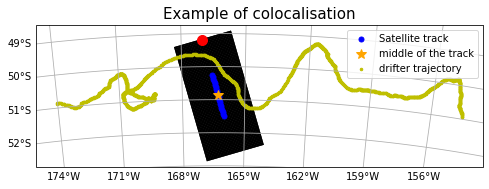

In [5]:
lonc=ds.box_lonc.values
latc=ds.box_latc.values

fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.Orthographic(lonc, latc)), figsize=(8,8))

#_ds = ds.isel(box_x=slice(0,None,10), box_y=slice(0,None,10))
ax.plot(ds.box_lon, ds.box_lat, "-", color="k", transform=crs);
ax.plot(ds.box_lon.T, ds.box_lat.T, "-", color="k", transform=crs);

#Satellite track
ax.plot(ds.alti_lon,ds.alti_lat, "o", ms=5, color="b", transform=crs, label='Satellite track')
#_ds = ds.sel(box_x=0, method="nearest").isel(box_y=-1)
ax.plot(lonc, latc, "*", ms=10, color="orange", transform=crs, label='middle of the track')

#Drifter trajectory
ax.plot(ds.drifter_lon,ds.drifter_lat, ".", ms=5, color="y", transform=crs, label='drifter trajectory')
#_ds = ds.sel(box_x=0, method="nearest").isel(box_y=-1)


_ds = ds.sel(box_y=0, method="nearest").isel(box_x=-1)
ax.plot(_ds.box_lon, _ds.box_lat, "o", ms=10, color="red", transform=crs)


gl = ax.gridlines(draw_labels=True, dms=False, 
                  x_inline=False, y_inline=False, 
                 )

gl.right_labels=False
gl.top_labels=False
plt.legend()
ax.set_title('Example of colocalisation', fontsize=15)

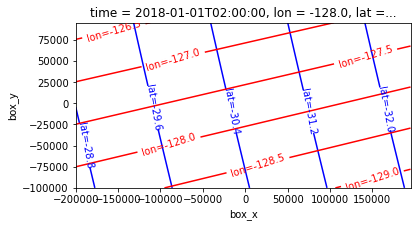

In [26]:
def plot_lonlat(ax):
    cs = ds["box_lat"].plot.contour(colors="b", linestyles="-")
    ax.clabel(cs, inline=1, fontsize=10, fmt= lambda x: f"lat={x:.1f}")
    cs = ds["box_lon"].plot.contour(colors="r", linestyles="-")
    ax.clabel(cs, inline=1, fontsize=10, fmt= lambda x: f"lon={x:.1f}")
    ax.set_aspect("equal")

fig, ax = plt.subplots(1,1)
plot_lonlat(ax)


## Show rotation angles

In [27]:
rad2deg = 180/np.pi

print(f" averaged theta_lon = {float(ds.box_theta_lon.mean())*rad2deg:.1f} deg")
print(f" averaged theta_lat = {float(ds.box_theta_lat.mean())*rad2deg:.1f} deg")
print(f" phi = {float(ds.box_phi):.1f} deg")

 averaged theta_lon = 103.3 deg
 averaged theta_lat = -166.7 deg
 phi = -103.3 deg


In [28]:
theta_lon_interp=ds.box_theta_lon.interp(box_x=ds.drifter_x, box_y=ds.drifter_y)
theta_lat_interp=ds.box_theta_lat.interp(box_x=ds.drifter_x, box_y=ds.drifter_y)
(theta_lon_interp-ds.drifter_theta_lon).max()

<xarray.DataArray ()>
dask.array<_nanmax_skip-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2018-01-01T02:00:00
    lon      float64 -128.0
    lat      float64 -30.49

Text(0.5, 1.0, 'box_theta_lon')

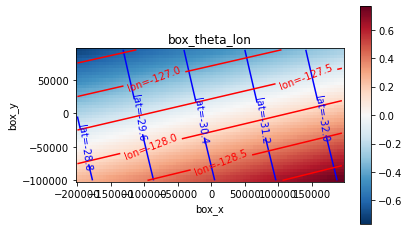

In [29]:
fig, ax = plt.subplots(1,1)
(rad2deg*ds["box_theta_lon"]+ds["box_phi"]).plot()
plot_lonlat(ax)
ax.set_title("box_theta_lon")

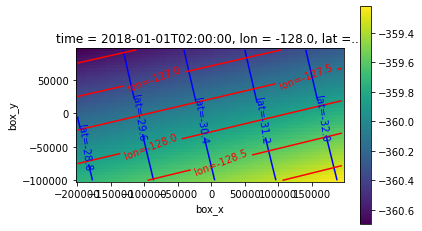

In [30]:
fig, ax = plt.subplots(1,1)
(rad2deg*ds["box_theta_lat"]+ds["box_phi"]-90).plot()
plot_lonlat(ax)

The difference between theta_lat and theta_lon is close but not quite $\pi/2$, the reason being the projection is not conformal (i.e. does not respect all angles):

Text(0.5, 1.0, 'box_theta_lat - box_theta_lon [deg]')

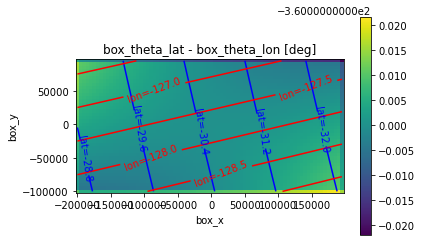

In [31]:
fig, ax = plt.subplots(1,1)
(rad2deg*(ds["box_theta_lat"]-ds["box_theta_lon"]) - 90 ).plot()
plot_lonlat(ax)
ax.set_title("box_theta_lat - box_theta_lon [deg]")

In [32]:
ds

<xarray.Dataset>
Dimensions:                        (site_obs: 1489, alti_time: 21, box_x: 80,
                                    box_y: 40, alti_time_mid: 20)
Coordinates: (12/19)
    time                           datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    lon                            float64 dask.array<chunksize=(), meta=np.ndarray>
    lat                            float64 dask.array<chunksize=(), meta=np.ndarray>
    drifter_time                   (site_obs) datetime64[ns] dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_lon                    (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_lat                    (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    ...                             ...
    alti_x                         (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    alti_y                         (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * alti_time                      (alti_time) int64 0 1 2 3 4 ... 17 18 19 20
  * alti_time_mid                  (alti_time_mid) float64 0.5 1.5 ... 18.5 19.5
    alti_x_mid                     (alti_time_mid) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    alti_y_mid                     (alti_time_mid) float64 dask.array<chunksize=(20,), meta=np.ndarray>
Dimensions without coordinates: site_obs
Data variables: (12/57)
    __site_id                      object dask.array<chunksize=(), meta=np.ndarray>
    __site_name                    object dask.array<chunksize=(), meta=np.ndarray>
    drifter_rowsize                (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_WMO                    (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_expno                  (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_deploy_date            (site_obs) datetime64[ns] dask.array<chunksize=(1489,), meta=np.ndarray>
    ...                             ...
    drifter_theta_lat              (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_vx                     (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_vy                     (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    g_grad_sla                     (alti_time_mid) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    g_grad_sla_denoised            (alti_time_mid) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    f                              float64 dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__gps
    __time_coverage_end:    2018-02-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [33]:
vxdiff=ds.drifter_x.differentiate("drifter_time", datetime_unit='s')
vydiff=ds.drifter_y.differentiate("drifter_time", datetime_unit='s')

NotImplementedError: dask array coordinated is not supported.

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
((ds.drifter_vx-vxdiff)/ds.drifter_vx).plot(ax=ax[0,0])
(ds.drifter_vx-vxdiff).plot(ax=ax[1,0])
((ds.drifter_vy-vydiff)/ds.drifter_vy).plot(ax=ax[0,1])
(ds.drifter_vy-vydiff).plot(ax=ax[1,1])
ax[0,0].set_title("(vxtheta-vxdiff) / vxtheta")
ax[1,0].set_title("vxtheta-vxdiff")
ax[0,1].set_title("(vytheta-vydiff) / vytheta")
ax[1,1].set_title("vytheta-vydiff")